In [1]:
!pip install sentencepiece
!pip install transformers
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requi

In [2]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel, GPT2Config
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import scipy
import numpy as np
import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# GPT2 with Generation Head

In [ ]:
config = GPT2Config.from_pretrained("gpt2")
config.do_sample = config.task_specific_params['text-generation']['do_sample']
config.max_length = config.task_specific_params['text-generation']['max_length']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
text = "Theoden was the only son of Thengel, and became king after the death"
encoded_input = tokenizer(text, return_tensors='pt')


`GPT2LMHeadModel` without `.generate` returns `B x T x V` tensor, where B is batch size, T - sequence length and V=50257 - GPT2 vocabulary size.

In [ ]:
logits = model(**encoded_input)['logits']
print(f"Logits tensor shape: {logits.shape}")

Logits tensor shape: torch.Size([1, 18, 50257])


 GPT-2 is trained so that the generation head predicts the next token at each position. If `ztj` is the logits tensor (`t=1..T`, `j=1..V`, we skip batch for simplicity), then the token `t+1` is predicted as `argmax`<sub>`j`</sub>`(ztj)
 `. It is an integer token which can be decoded by the tokenizer.
But what is the meaning of logits at position `T` (the last position)? It is the prediction of the next token after the current T-sequence. <br>

Source: https://www.it-jim.com/blog/training-and-fine-tuning-gpt-2-and-gpt-3-models-using-hugging-face-transformers-and-openai-api/

In [ ]:
input_ids = encoded_input.input_ids
attention_mask=encoded_input.attention_mask
output = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                        do_sample=True, temperature=1.0, max_length=30)
tokenizer.batch_decode(output)[0]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1256: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Theoden was the only son of Thengel, and became king after the death of Anha in 642 BC. He married Queen El'

In [ ]:
# non-random generation
# 'predict' the word with highest logit value
input_ids = encoded_input.input_ids
for i in range(30):
  attention_mask = torch.ones(input_ids.shape, dtype=torch.int64)
  logits = model(input_ids=input_ids, attention_mask=attention_mask)['logits']
  new_id = logits[:, -1, :].argmax(dim=1)  # Generate new ID
  input_ids = torch.cat([input_ids, new_id.unsqueeze(0)], dim=1)

print(tokenizer.batch_decode(input_ids)[0])


Theoden was the only son of Thengel, and became king after the death of his father. He was the son of the king of the Dothraki, and was the son of the king of the Dothra


In [ ]:
# random generation
# actually sample from all possible words within vocabulary
temperature=1
input_ids = encoded_input.input_ids
words = torch.arange(50257).reshape(1, -1)
for i in range(30):
  attention_mask = torch.ones(input_ids.shape, dtype=torch.int64)
  logits = model(input_ids=input_ids, attention_mask=attention_mask)['logits']
  softmax = torch.nn.functional.softmax(logits[:,-1,:] / temperature, dim=1)  # prediction of next token based on last token in current sequence
  softmax_numpy = softmax.detach().numpy()
  softmax_np_norm = softmax_numpy / np.sum(softmax_numpy)
  dist = scipy.stats.rv_discrete(values=(words, softmax_np_norm))
  new_id = torch.tensor([dist.rvs()])
  input_ids = torch.cat([input_ids, new_id.unsqueeze(0)], dim=1)
print(tokenizer.batch_decode(input_ids)[0])

Theoden was the only son of Thengel, and became king after the death of his wife; he lived in captivity for a thousand years at Abyingham, on Lake UniTrad. Emperor Dverbrota, aged


# Words algebra


Just a fun experiment to see these famous manipulations with word embeddings.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

In [ ]:
words_list = ["cat", "dog", "horse", "plane"]

In [ ]:
def create_outputs_dict(tensor):
  outputs = {}
  for i, word in enumerate(words_list):
    outputs[word] = tensor[i]
  return outputs

In [ ]:
def return_sorted_distances_and_similarities(outputs):
  distances = {}
  similarities = {}
  for i, first_word in enumerate(words_list):
    other_words = words_list[i+1:]
    for second_word in other_words:
      dist = round(torch.norm(outputs[first_word] - outputs[second_word]).item(), 2)
      sim = round(torch.nn.functional.cosine_similarity(outputs[first_word].flatten(), outputs[second_word].flatten(), dim=0).item(), 2)
      distances[f"{first_word} - {second_word}"] = dist
      similarities[f"{first_word} - {second_word}"] = sim
  sorted_dist = sorted(distances.items(), key=lambda x: x[1], reverse=True)
  sorted_sim = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
  return sorted_dist, sorted_sim

### With generation head

In [ ]:
model = GPT2LMHeadModel.from_pretrained("gpt2", output_hidden_states=True)
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
encoded_input = tokenizer(words_list, padding=True, return_tensors='pt')
output = model(**encoded_input)
last_hid_state = output['hidden_states'][0]

In [ ]:
print(f"Output shape of GPT2LMHeadModel: {last_hid_state.shape} - `Batch size X Sequence length X Embedding vestor size`")

Output shape of GPT2LMHeadModel: torch.Size([4, 1, 768]) - `Batch size X Sequence length X Embedding vestor size`


In [ ]:
outputs = create_outputs_dict(last_hid_state)
sorted_dist, sorted_sim = return_sorted_distances_and_similarities(outputs)

In [ ]:
sorted_dist

[('cat - plane', 5.32),
 ('dog - plane', 5.16),
 ('horse - plane', 5.13),
 ('cat - horse', 4.89),
 ('dog - horse', 4.58),
 ('cat - dog', 4.49)]

In [ ]:
sorted_sim

[('cat - dog', 0.91),
 ('dog - horse', 0.91),
 ('cat - horse', 0.89),
 ('horse - plane', 0.89),
 ('cat - plane', 0.88),
 ('dog - plane', 0.88)]

### GPT2 Bare model

In [ ]:
bare_model = GPT2Model.from_pretrained("gpt2")
bare_model.config.pad_token_id = bare_model.config.eos_token_id

In [ ]:
encoded_input = tokenizer(words_list, padding=True, return_tensors='pt')
output = bare_model(**encoded_input)
last_hid_state = output.last_hidden_state

In [ ]:
print(f"Output shape of bare GPT2 model: {last_hid_state.shape} - `Batch size X Sequence length X Embedding vestor size`")

Output shape of bare GPT2 model: torch.Size([4, 1, 768]) - `Batch size X Sequence length X Embedding vestor size`


In [ ]:
outputs = create_outputs_dict(last_hid_state)
sorted_dist, sorted_sim = return_sorted_distances_and_similarities(outputs)


In [ ]:
sorted_dist

[('car - plane', 8.96),
 ('car - train', 6.47),
 ('bus - plane', 6.27),
 ('train - plane', 5.92),
 ('car - bus', 5.6),
 ('bus - train', 3.91)]

In [ ]:
sorted_sim

[('car - bus', 1.0),
 ('car - train', 1.0),
 ('bus - train', 1.0),
 ('bus - plane', 1.0),
 ('train - plane', 1.0),
 ('car - plane', 0.99)]

Although the difference between distances and similarities is tiny, `GPT2LMHeadModel` seems to be more consistent and shows expected logic: words from one similarity group (e.g. animals) having "smaller distance" between each other and words from different groups (e.g. animals and fruits) having "bigger distance".

# Train GPT-2 on new text

In [3]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from matplotlib.pylab import plt
from numpy import arange

In [4]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
lotr_dataset = load_dataset("JeremyArancio/lotr-book")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"USING {device}")

Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

USING cuda


In [6]:
text = lotr_dataset['train']['text'][0]
print(f"Text beginning: {text[:50]}\nText end: {text[-50:]}")

Text beginning: Chapter 1 A LONG-EXPECTED PARTY When Mr. Bilbo Bag
Text end: >He drew a deep breath. ‘Well, I’m back,’ he said.


In [7]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'])

In [8]:
tokenized_dataset = lotr_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (631143 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
len(tokenized_dataset['train']['input_ids'][0])

631143

In [10]:
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in ['input_ids', 'attention_mask']}
    total_length = len(concatenated_examples['input_ids'])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    return result

In [11]:
lm_datasets = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=1000
)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [12]:
class LotrDataset(torch.utils.data.Dataset):
  def __init__(self, data: list[list[int]]):
    self.data = []
    for d in data:
      input_ids = torch.tensor(d, dtype=torch.int64)
      attention_mask = torch.ones(len(d), dtype=torch.int64)
      self.data.append({'input_ids': input_ids,
                        'attention_mask': attention_mask,
                        'labels': input_ids})
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx: int):
    return self.data[idx]

In [13]:
train, val = train_test_split(lm_datasets['train']['input_ids'], test_size=0.2)

In [14]:
train_torch = LotrDataset(train)
val_torch = LotrDataset(val)

In [15]:
loader_train = torch.utils.data.DataLoader(train_torch, batch_size=1)
loader_val = torch.utils.data.DataLoader(val_torch, batch_size=1)

In [22]:
for batch in loader_train:
  batch
  break

In [28]:
batch['labels'].shape

torch.Size([1, 128])

In [ ]:
def train_one(model_, loader, optimizer):
  """Standard PyTorch training, one epoch"""
  model_.train()
  losses = []
  # for batch in tqdm.tqdm(loader):
  for batch in loader:
    for k, v in batch.items():
      batch[k] = v.to(device)
  optimizer.zero_grad()
  out = model_(input_ids=batch['input_ids'],
              attention_mask=batch['attention_mask'],
              labels=batch['labels'])
  loss = out['loss']
  loss.backward()
  optimizer.step()
  losses.append(loss.item())

  return np.mean(losses)


In [ ]:
def val_one(model_, loader):
  """Standard PyTorch training, one epoch"""
  model_.eval()
  losses = []
  with torch.no_grad():
    # for batch in tqdm.tqdm(loader):
    for batch in loader:
      for k, v in batch.items():
        batch[k] = v.to(device)
    out = model_(input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels'])
    loss = out['loss']
    losses.append(loss.item())

  return np.mean(losses)

### Without layers freezing

In [ ]:
trained_model = GPT2LMHeadModel.from_pretrained("gpt2")
trained_model.to(device)
optimizer = torch.optim.Adam(trained_model.parameters(), lr=1e-3)

In [ ]:
train_losses = []
val_losses = []
for i_epoch in range(20):
  loss_train = train_one(trained_model, loader_train, optimizer)
  train_losses.append(loss_train)
  loss_val = val_one(trained_model, loader_val)
  val_losses.append(loss_val)
  print(f'{i_epoch} : loss_train={loss_train}, loss_val={loss_val}\n')

0 : loss_train=4.799004077911377, loss_val=6.563765525817871

1 : loss_train=3.3388025760650635, loss_val=7.421602249145508

2 : loss_train=2.279510974884033, loss_val=7.70756721496582

3 : loss_train=1.54532790184021, loss_val=8.256463050842285

4 : loss_train=0.8187422156333923, loss_val=9.03151798248291

5 : loss_train=0.5124562978744507, loss_val=9.76542854309082

6 : loss_train=0.2744135856628418, loss_val=10.498847007751465

7 : loss_train=0.07577387243509293, loss_val=11.323142051696777

8 : loss_train=0.11707029491662979, loss_val=11.856006622314453

9 : loss_train=0.02097695879638195, loss_val=12.60007095336914

10 : loss_train=0.047780197113752365, loss_val=13.213335037231445

11 : loss_train=0.05396345630288124, loss_val=13.885174751281738

12 : loss_train=0.08496330678462982, loss_val=13.752906799316406

13 : loss_train=0.05608168989419937, loss_val=14.16462516784668

14 : loss_train=0.03800655156373978, loss_val=14.438047409057617

15 : loss_train=0.07313678413629532, loss

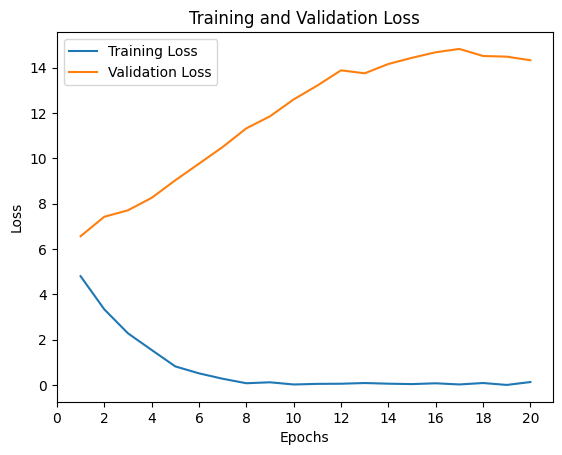

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(arange(0, len(train_losses) + 1, 2))

plt.legend(loc='best')
plt.show()

In [ ]:
text = "Where was Gondor when Westfold fell?"
encoded_input = tokenizer(text, return_tensors='pt')
input_ids=encoded_input.input_ids.to(device)
attention_mask=encoded_input.attention_mask.to(device)
output = trained_model.generate(input_ids=input_ids, attention_mask=attention_mask,
                        do_sample=True, max_length=50)
tokenizer.batch_decode(output)[0]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Where was Gondor when Westfold fell? Not all those who wander are lost; The old that is gold does not glitter, Not all those who wander are lost; The old that is gold does not glitter, Not all those who wander are'

### With layers freezeing

https://www.kaggle.com/code/masaishi/training-gpt-2-for-generating-reviews-from-title

In [ ]:
trained_model_freeze = GPT2LMHeadModel.from_pretrained("gpt2")
trained_model_freeze.to(device);


In [ ]:
UNFREEZE_LAST_N = 4

for parameter in trained_model_freeze.parameters():
    parameter.requires_grad = False

for i, m in enumerate(trained_model_freeze.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > 12 - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

for parameter in trained_model_freeze.transformer.ln_f.parameters():
    parameter.requires_grad = True

for parameter in trained_model_freeze.lm_head.parameters():
    parameter.requires_grad = True


In [ ]:
optimizer = torch.optim.Adam(trained_model_freeze.parameters(), lr=1e-3)

In [ ]:
train_losses = []
val_losses = []
for i_epoch in range(10):
  loss_train = train_one(trained_model_freeze, loader_train, optimizer)
  train_losses.append(loss_train)
  loss_val = val_one(trained_model_freeze, loader_val)
  val_losses.append(loss_val)
  # print(f'{i_epoch} : loss_train={loss_train}, loss_val={loss_val}\n')

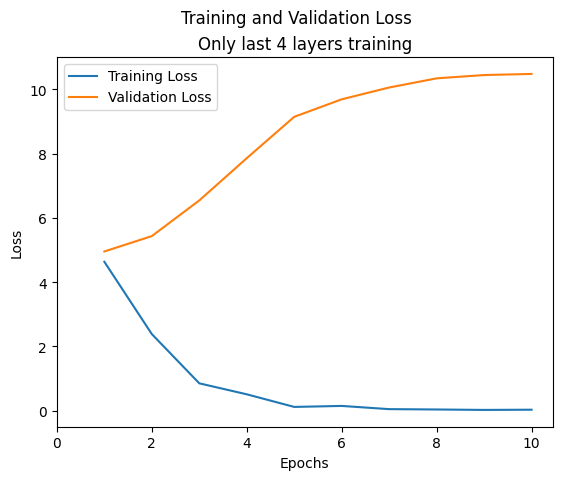

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")

plt.suptitle('Training and Validation Loss')
plt.title(f"Only last {UNFREEZE_LAST_N} layers training")
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(arange(0, len(train_losses) + 1, 2))

plt.legend(loc='best')
plt.show()

In [ ]:
text = "Bilbo Baggins celebrates his birthday and leaves the Ring to"
encoded_input = tokenizer(text, return_tensors='pt')
input_ids=encoded_input.input_ids.to(device)
attention_mask=encoded_input.attention_mask.to(device)
output = trained_model_freeze.generate(input_ids=input_ids, attention_mask=attention_mask,
                        do_sample=True, max_length=100)
tokenizer.batch_decode(output)[0]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Bilbo Baggins celebrates his birthday and leaves the Ring to wander proudly on. Standing suddenly up he burst out: All that is gold does not glitter, Not all those who wander are lost; The old that is in his past; The old that is in his past, The old that is in his past, The old that is in his past, The old that is in his past. Standing suddenly up he burst out: The old that is in his past, The old that is in'

# Train classifier
Data set is reviews from Rotten Tomatoes available on Kaggle (https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset?select=rotten_tomatoes_critic_reviews.csv)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.pylab import plt
import torch.nn as nn
import torch.nn.functional as F
from numpy import arange

In [ ]:
bare_model = GPT2Model.from_pretrained("gpt2")

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"USING {device}")

bare_model.to(device);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

USING cuda


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks


In [ ]:
critics_df = pd.read_csv("rotten_tomatoes_critic_reviews.csv", usecols=["review_type", "review_content"])
critics_df.dropna(inplace=True)
# movies_df = pd.read_csv("rotten_tomatoes_movies.csv")


In [ ]:
print(f"Size of critics df: {len(critics_df)} reviews.")

Size of critics df: 1064211 reviews.


In [ ]:
critics_df.head()

,review_type,review_content
0,Fresh,A fantasy adventure that fuses Greek mythology...
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,Fresh,With a top-notch cast and dazzling special eff...
3,Fresh,Whether audiences will get behind The Lightnin...
4,Rotten,What's really lacking in The Lightning Thief i...


In [ ]:
critics_df['review_type'] = critics_df['review_type'].map({"Fresh": 1, "Rotten": 0})

In [ ]:
critics_df["review_type"].value_counts()

,count
review_type,
1,681035
0,383176


In [ ]:
print(f"No Nones in df: {critics_df['review_content'].isna().sum()==0}")

No Nones in df: True


In [ ]:
df_short, _ = train_test_split(critics_df, test_size=0.95, random_state=42, stratify=critics_df["review_type"])
train_df, test_df = train_test_split(df_short, test_size=0.2, random_state=42, stratify=df_short["review_type"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["review_type"])

In [ ]:
train_df.head()

,review_type,review_content
111002,1,There's a smart and welcome sense of humour to...
1068927,0,"It patronises the older generation by going, ""..."
405608,1,Acaba soando mais como preparativo para os aco...
49132,1,"This century's Planet of the Apes is a rouser,..."
468369,1,The film doesn't dwell exploitively on these t...


In [ ]:
class PTDataset(torch.utils.data.Dataset):
  def __init__(self, data: pd.DataFrame):
    self.data = data
    self.max_len = self.logest_seq_len()

  def __len__(self):
    return len(self.data)

  def logest_seq_len(self):
    lens = self.data.review_content.str.len()
    index = lens.idxmax()
    max_len = len(self.data.loc[index].review_content)
    return max_len


  def __getitem__(self, idx: int):
    row = self.data.iloc[idx]
    review = row['review_content']
    score = row['review_type']
    tokenized_review = tokenizer(review, padding='max_length', max_length=self.max_len, return_tensors="pt")
    return {'input_ids': tokenized_review['input_ids'][0],
            'attention_mask': tokenized_review['attention_mask'][0],
            'labels': score}

In [ ]:
class PTClassifier(nn.Module):
  def __init__(self):
    super(PTClassifier, self).__init__()
    self.linear1 = nn.Linear(768, 120)
    self.linear2 = nn.Linear(120, 60)
    self.linear3 = nn.Linear(60, 2)
    self.dropout = nn.Dropout(0.2)

  def forward(self, input_ids, attention_mask):
    with torch.no_grad():
      output = bare_model(input_ids=input_ids, attention_mask=attention_mask)
    x = output.last_hidden_state[:, -1, :]
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    return x


In [ ]:
train_data_pt = PTDataset(train_df)
test_data_pt = PTDataset(test_df)
val_data_pt = PTDataset(val_df)

train_loader = torch.utils.data.DataLoader(train_data_pt, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_pt, batch_size=10)
val_loader = torch.utils.data.DataLoader(val_data_pt, batch_size=10, shuffle=False)

In [ ]:
AVERAGE = "weighted"

classifier = PTClassifier().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

train_data_pt = PTDataset(train_df)
test_data_pt = PTDataset(test_df)
val_data_pt = PTDataset(val_df)

train_loader = torch.utils.data.DataLoader(train_data_pt, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_pt, batch_size=16)
val_loader = torch.utils.data.DataLoader(val_data_pt, batch_size=16, shuffle=False)


train_losses = []
train_f1_list = []
val_looses = []
val_f1_list = []
for i in range(10):
  running_t_loss = 0
  print(f"EPOCH {i+1}")
  classifier.train()
  running_loss = 0
  predictions = []
  actual = []
  last_loss = 0
  for batch in tqdm.tqdm(train_loader):
    for k, v in batch.items():
      batch[k] = v.to(device)
    input_ids = batch['input_ids']
    mask = batch['attention_mask']
    label = batch['labels']
    optimizer.zero_grad()

    output = classifier(input_ids, mask).squeeze()
    loss = loss_fn(output, label)
    predictions.extend(output.argmax(dim=1).tolist())
    actual.extend(label.tolist())
    loss.backward()
    optimizer.step()

    running_t_loss += loss.item()

  train_accuracy = accuracy_score(actual, predictions)
  train_f1 = f1_score(actual, predictions)
  train_recall = recall_score(actual, predictions)
  train_precision = precision_score(actual, predictions)
  av_epoch_loss = running_t_loss / len(train_loader)
  print("Training loss: {:.2f}".format(av_epoch_loss))
  print("Training accuracy: {:.2f}".format(train_accuracy))
  print("Training f1: {:.2f}".format(train_f1))
  print("Training recall: {:.2f}".format(train_recall))
  print("Training precision: {:.2f}".format(train_precision))
  train_losses.append(av_epoch_loss)
  train_f1_list.append(train_f1)

  classifier.eval()
  running_v_loss = 0
  predictions = []
  actual = []
  with torch.no_grad():
    for batch in tqdm.tqdm(val_loader):
      for k, v in batch.items():
        batch[k] = v.to(device)
      input_ids = batch['input_ids']
      mask = batch['attention_mask']
      label = batch['labels']

      output = classifier(input_ids, mask).squeeze()
      predictions.extend(output.argmax(dim=1).tolist())
      actual.extend(label.tolist())
      loss = loss_fn(output, label)
      running_v_loss += loss.item()

    val_accuracy = accuracy_score(actual, predictions)
    val_f1 = f1_score(actual, predictions)
    val_recall = recall_score(actual, predictions)
    val_precision = precision_score(actual, predictions)
    av_epoch_loss = running_v_loss / len(val_loader)
    print("Average validation loss: {:.2f}".format(av_epoch_loss))
    print("Validation accuracy: {:.2f}".format(val_accuracy))
    print("Validation f1: {:.2f}".format(val_f1))
    print("Validation recall: {:.2f}".format(val_recall))
    print("Validation precision: {:.2f}".format(val_precision))
    val_looses.append(av_epoch_loss)
    val_f1_list.append(val_f1)

    print("\n")





EPOCH 1


100%|██████████| 2129/2129 [08:30<00:00,  4.17it/s]


Training loss: 0.65
Training accuracy: 0.64
Training f1: 0.78
Training recall: 0.98
Training precision: 0.64


100%|██████████| 533/533 [02:02<00:00,  4.36it/s]


Average validation loss: 0.62
Validation accuracy: 0.65
Validation f1: 0.78
Validation recall: 0.98
Validation precision: 0.65


EPOCH 2


100%|██████████| 2129/2129 [08:30<00:00,  4.17it/s]


Training loss: 0.62
Training accuracy: 0.65
Training f1: 0.77
Training recall: 0.92
Training precision: 0.66


100%|██████████| 533/533 [02:02<00:00,  4.35it/s]


Average validation loss: 0.60
Validation accuracy: 0.67
Validation f1: 0.78
Validation recall: 0.90
Validation precision: 0.68


EPOCH 3


100%|██████████| 2129/2129 [08:30<00:00,  4.17it/s]


Training loss: 0.60
Training accuracy: 0.67
Training f1: 0.77
Training recall: 0.88
Training precision: 0.69


100%|██████████| 533/533 [02:02<00:00,  4.36it/s]


Average validation loss: 0.59
Validation accuracy: 0.68
Validation f1: 0.78
Validation recall: 0.89
Validation precision: 0.69


EPOCH 4


100%|██████████| 2129/2129 [08:30<00:00,  4.17it/s]


Training loss: 0.59
Training accuracy: 0.68
Training f1: 0.77
Training recall: 0.86
Training precision: 0.70


100%|██████████| 533/533 [02:02<00:00,  4.36it/s]


Average validation loss: 0.58
Validation accuracy: 0.69
Validation f1: 0.79
Validation recall: 0.90
Validation precision: 0.70


EPOCH 5


100%|██████████| 2129/2129 [08:30<00:00,  4.17it/s]


Training loss: 0.58
Training accuracy: 0.68
Training f1: 0.77
Training recall: 0.85
Training precision: 0.71


100%|██████████| 533/533 [02:02<00:00,  4.36it/s]


Average validation loss: 0.58
Validation accuracy: 0.69
Validation f1: 0.78
Validation recall: 0.84
Validation precision: 0.72


EPOCH 6


100%|██████████| 2129/2129 [08:30<00:00,  4.17it/s]


Training loss: 0.58
Training accuracy: 0.68
Training f1: 0.78
Training recall: 0.85
Training precision: 0.71


100%|██████████| 533/533 [02:02<00:00,  4.36it/s]


Average validation loss: 0.58
Validation accuracy: 0.69
Validation f1: 0.78
Validation recall: 0.84
Validation precision: 0.72


EPOCH 7


100%|██████████| 2129/2129 [08:30<00:00,  4.17it/s]


Training loss: 0.57
Training accuracy: 0.69
Training f1: 0.78
Training recall: 0.85
Training precision: 0.72


100%|██████████| 533/533 [02:02<00:00,  4.35it/s]


Average validation loss: 0.58
Validation accuracy: 0.69
Validation f1: 0.78
Validation recall: 0.85
Validation precision: 0.72


EPOCH 8


100%|██████████| 2129/2129 [08:30<00:00,  4.17it/s]


Training loss: 0.57
Training accuracy: 0.69
Training f1: 0.78
Training recall: 0.85
Training precision: 0.72


100%|██████████| 533/533 [02:02<00:00,  4.35it/s]


Average validation loss: 0.58
Validation accuracy: 0.69
Validation f1: 0.77
Validation recall: 0.82
Validation precision: 0.73


EPOCH 9


100%|██████████| 2129/2129 [08:30<00:00,  4.17it/s]


Training loss: 0.57
Training accuracy: 0.70
Training f1: 0.78
Training recall: 0.85
Training precision: 0.72


100%|██████████| 533/533 [02:02<00:00,  4.35it/s]


Average validation loss: 0.57
Validation accuracy: 0.70
Validation f1: 0.79
Validation recall: 0.86
Validation precision: 0.72


EPOCH 10


100%|██████████| 2129/2129 [08:31<00:00,  4.16it/s]


Training loss: 0.56
Training accuracy: 0.70
Training f1: 0.78
Training recall: 0.85
Training precision: 0.73


100%|██████████| 533/533 [02:02<00:00,  4.35it/s]

Average validation loss: 0.58
Validation accuracy: 0.69
Validation f1: 0.76
Validation recall: 0.78
Validation precision: 0.74




In [ ]:
output

[0, 0, 0, 0, 1, 1, 1, 1, 0, 1]

In [ ]:
output.argmax(dim=1).tolist()

[0, 0, 0, 0, 0, 0, 1, 1, 0, 1]

In [ ]:
sum(output.argmax(dim=1) == label).item()

8

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_looses, label="Validation Loss")

plt.suptitle('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(arange(0, len(train_losses) + 1, 2))

plt.legend(loc='best')
plt.show()

NameError: name 'train_losses' is not defined

In [ ]:
train_losses_total

[[14.58494879950861,
  14.15936971480976,
  13.938198999861438,
  13.768645314568115,
  13.623736811454426,
  13.62351907787519],
 [13.577487088510118,
  13.527218252901815,
  13.685855788981511,
  13.720759374279632,
  13.521607585940592,
  13.472736940509947]]

In [ ]:
train_losses_total = train_losses_total[0]+train_losses_total[1]
val_looses_total = val_looses_total[0]+val_looses_total[1]

# Git

In [ ]:
from getpass import getpass


In [ ]:
token = getpass('Enter your GitHub token: ')

# Set up repository URL with token
repo_url = f"https://{token}@github.com/sizovaj95/LLMPlayground.git"

Enter your GitHub token: ··········


In [ ]:
!git config --global user.email ""
!git config --global user.name "sizovaj95"

In [ ]:
!git clone {repo_url}

Cloning into 'LLMPlayground'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
%ls

drive/  sample_data/
